# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme opencv-python matplotlib albumentations

In [ ]:
!pip install "tensorflow<2.11"

### 1.2 Collect Images Using OpenCV (Optional)
This step will open up a webcam window on your machine and start taking picture every 0.5 seconds. Ignore this step if you already have data images ready


In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 5

In [ ]:
# Take pictures from a webcam every 0.5s
cap = cv2.VideoCapture(0)     
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe 
This will open labelme library to start labeling images.

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function
This step is to create a TF data pipeline for data partition 

### 2.1 Import TF and Deps

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

### 2.3 Load Image into TF Data Pipeline

In [ ]:
# Load files into image variable
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
# load images using tensorflow
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib for visualization (Optional)

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL
We can use sklearn library for this also

In [ ]:
95*.7 # 66

In [ ]:
95*.15 # 28

### 3.2 Move the Matching Labels

In [ ]:
# Script for copying the label data into to train, test, val folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations
This step increase the data size make the images become more diverse

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON for visualization

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','1fd5c643-fe91-11ed-80ad-ac12033ad36e.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '1fd5c643-fe91-11ed-80ad-ac12033ad36e.json'), 'r') as f:
    label = json.load(f)

In [28]:
# label
label['shapes'][0]['points']

[[143.05389221556885, 150.47904191616763],
 [278.9820359281437, 298.9820359281437]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]   # x1
coords[1] = label['shapes'][0]['points'][0][1]   # y1
coords[2] = label['shapes'][0]['points'][1][0]   # x2
coords[3] = label['shapes'][0]['points'][1][1]   # y2

In [ ]:
coords

In [ ]:
# Divide to get the coordinate in range of 0 - 1 divide x by width and y by height
width = 640
height = 480
coords = list(np.divide(coords, [width, height, width, height]))

In [ ]:
coords

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][0:2]

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
# Draw a rectangle to show your label that you created
# Multiply by 450 to transform the box back to normal size
SCALE_BOX = 450
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [SCALE_BOX,SCALE_BOX]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [SCALE_BOX,SCALE_BOX]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline
Load images and labels and create 60 images from an original image with augmentor

In [ ]:
IMAGE_NUM = 60
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(IMAGE_NUM):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                # Set up a json object to write to the label folder
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
IMAGE_SIZE = 120

In [10]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (IMAGE_SIZE,IMAGE_SIZE)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (IMAGE_SIZE,IMAGE_SIZE)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (IMAGE_SIZE,IMAGE_SIZE)))
val_images = val_images.map(lambda x: x/255)

In [14]:
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset
Create labels for train, test, and val

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3027, 0.238 , 0.545 , 0.576 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)
Using `tf.data.Dataset.zip` to combine images and their labels

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [30]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### 7.3 View Images and Annotations
View some image samples

In [38]:
data_samples = train.as_numpy_iterator()

In [39]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [41]:
# Get rid of the final layers of VGG16 to create our own
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 12s 0us/step


In [ ]:
vgg.summary()

### 8.3 Build instance of Network
Input will go ino the pre-trained VGG16 model and break down into 2 models for output, Classification and Regression Model.

In [45]:
IMAGE_SIZE=120

In [47]:
def build_model(): 
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)       
    class2 = Dense(1, activation='sigmoid')(class1)   # Output 
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [48]:
facetracker = build_model()

In [49]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [50]:
X, y = train.as_numpy_iterator().next()

In [51]:
X.shape

(8, 120, 120, 3)

In [52]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 9s 9s/step


In [53]:
classes, coords

(array([[0.43704543],
        [0.5208616 ],
        [0.41195247],
        [0.52849025],
        [0.49640924],
        [0.47279677],
        [0.49700975],
        [0.5473064 ]], dtype=float32),
 array([[0.37652805, 0.60857815, 0.5407859 , 0.40758342],
        [0.4033186 , 0.5628636 , 0.5080429 , 0.43718547],
        [0.4180395 , 0.560022  , 0.4838693 , 0.4674911 ],
        [0.31793508, 0.57982653, 0.479166  , 0.44376436],
        [0.39881057, 0.5679002 , 0.48350194, 0.45047498],
        [0.4244554 , 0.59826297, 0.4639334 , 0.47407794],
        [0.43974033, 0.58670396, 0.48616415, 0.4815431 ],
        [0.38330093, 0.5580594 , 0.41067818, 0.4651181 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR
Set up equation for losses

In [56]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [57]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss
https://stats.stackexchange.com/questions/298919/can-you-brief-the-training-procedure-of-ssd-in-tf-object-detection-api

In [58]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [59]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [60]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7112975>

In [61]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70407724>

In [62]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7112975>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [65]:
# Create a subclass
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        # Back propagation
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss+0.5*batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)      
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [66]:
model = FaceTracker(facetracker)

In [67]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [68]:
logdir='logs'

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [120]:
hist = model.fit(train, epochs=8, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
473/473 [==============================] - 18s 31ms/step - total_loss: 0.0065 - class_loss: 0.0013 - regress_loss: 0.0058 - val_total_loss: 0.1511 - val_class_loss: 0.1376 - val_regress_loss: 0.0823
Epoch 2/8
473/473 [==============================] - 17s 29ms/step - total_loss: 0.0129 - class_loss: 0.0047 - regress_loss: 0.0105 - val_total_loss: 0.0580 - val_class_loss: 0.0022 - val_regress_loss: 0.0569
Epoch 3/8
473/473 [==============================] - 17s 30ms/step - total_loss: 0.0085 - class_loss: 9.2001e-04 - regress_loss: 0.0081 - val_total_loss: 0.5525 - val_class_loss: 0.6770 - val_regress_loss: 0.2141
Epoch 4/8
473/473 [==============================] - 17s 30ms/step - total_loss: 0.0035 - class_loss: 2.8203e-04 - regress_loss: 0.0034 - val_total_loss: 1.3255 - val_class_loss: 0.7969 - val_regress_loss: 0.9271
Epoch 5/8
473/473 [==============================] - 17s 29ms/step - total_loss: 0.0042 - class_loss: 8.7493e-04 - regress_loss: 0.0038 - val_total_loss: 0.

### 10.3 Plot Performance

In [ ]:
hist.history

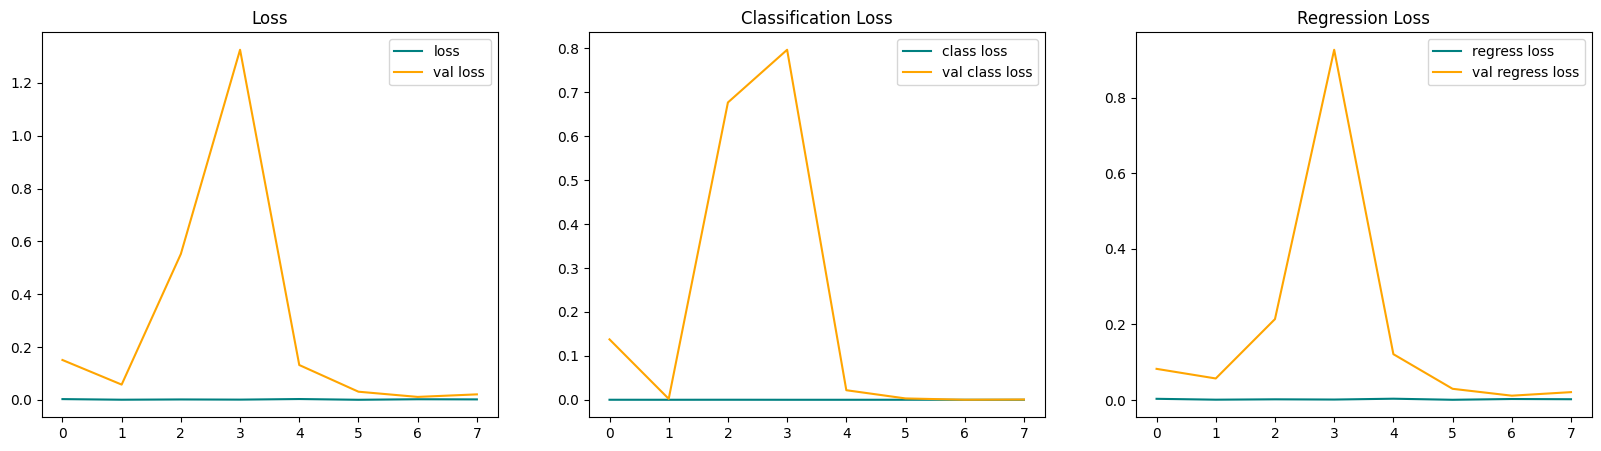

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [123]:
test_data = test.as_numpy_iterator()

In [124]:
test_sample = test_data.next()

In [125]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 15ms/step


In [126]:
# This is the classification output 0 - 1 if it is a face or not
yhat[0][0]

array([0.9999999], dtype=float32)

In [127]:
# This is the regression model output to show the box coordinate
yhat[1][0]

array([0.01041161, 0.08421997, 0.31067523, 0.58891517], dtype=float32)

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 1)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [129]:
from tensorflow.keras.models import load_model

In [130]:
facetracker.save('./models/facetracker.h5')

In [131]:
facetracker = load_model('./models/facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()   # Get the each frame in a video capture
    frame = frame[50:500, 50:500,:]

    # Convert and resize image
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    # Predict
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()